## Табличное Q-обучение


Одним из наиболее популярных алгоритм обучения на основе временных различий является Q-обучение.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/678cb558a9d59c33ef4810c9618baf34a9577686">


<!-- Раскроем скобки:
$$Q(s,a)\leftarrow (1 - \alpha) \times Q(s,a)+\alpha \times \big (r(s)+\gamma\max_{a'}Q(a',s')\big ).$$ -->

Для обучения будем использовать среду Taxi-v3. Подробнее про данное окружение можно посмотреть в документации: https://gymnasium.farama.org/environments/toy_text/taxi/.

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

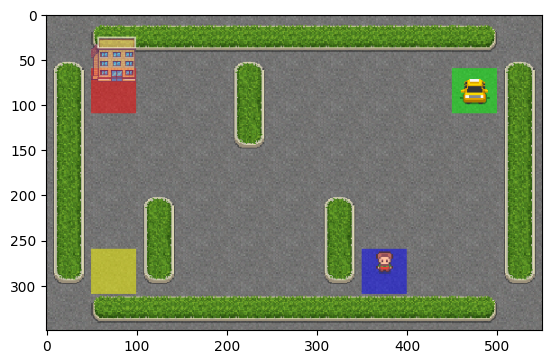

In [3]:
env = gym.make("Taxi-v3", render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [4]:
def show_progress(rewards_batch, log):
    """Функция отображения прогресса обучения."""
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)

    clear_output(True)
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(log, label='Mean rewards')
    plt.legend(loc=4)
    plt.show()

### Задание 1

Создайте таблицу из нулей, используя информацию из окружения о количестве состояний и действий (1 балл)

In [5]:
def initialize_q_table(n_observation_space, n_action_space):
    # Q = [state][action]
    ####### Здесь ваш код ########
    Q = np.zeros((n_observation_space, n_action_space))
    ##############################
    return Q

In [6]:
# Добавить проверку таблицы - размеры, тип.
n_states, n_actions = 3, 5
Q = initialize_q_table(n_states, n_actions)
assert isinstance(Q, np.ndarray) and len(Q.shape) == 2, 'результат должен быть 2D нумпаевским вектором'
assert Q.shape[0] == n_states and Q.shape[1] == n_actions, 'проверь размерности: [N состояний][M действий]'
assert not Q.any(), 'инициализация должна быть нулями'

### Задание 2

Напишите код для epsilon-жадного выбора действия (1 балл):

In [8]:
def select_action_eps_greedy(Q, state, epsilon):
    # выбираем действие, используя eps-greedy исследование среды:
    # 1) с вероятностью epsilon выбираем случайное действие,
    # 2) иначе выбираем действие жадно
    # action =
    ####### Здесь ваш код ########
    if np.random.random() < epsilon:
        action = np.random.randint(0, Q.shape[1])
    else:
        action = np.argmax(Q[state])
    ##############################
    return action

Напишите код для формулы Q-обновления (1 балл):

In [9]:
def update_Q(Q, s, a, r, next_s, alpha, gamma):
    # alpha: learning rate, gamma: discount factor
    # вычисли V(next_s) - estimate of optimal future value
    # V_ns =
    ####### Здесь ваш код ########
    V_ns = np.max(Q[next_s])
    ##############################

    # посчитай TD ошибку
    # td_error =
    ####### Здесь ваш код ########
    td_error = r + gamma * V_ns - Q[s, a]
    ##############################

    # обновление Q-функции
    Q[s, a] += alpha * td_error


Допишите код итерации Q-обучения (2 балла):

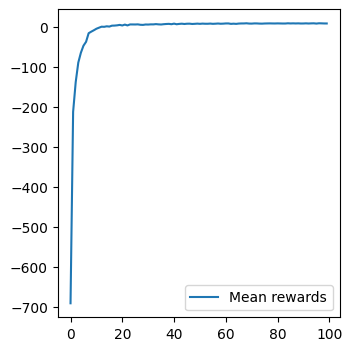

Episode: 10000, Reward: 7, Eps: 0.001246427204280841


In [10]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
n_episodes = 10000

for i_episode in range(1, n_episodes + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    terminated = False

    while not terminated:
        # select action eps-greedy
        # a = ...
        ####### Здесь ваш код ########
        a = select_action_eps_greedy(Q, s, epsilon)
        ##############################

        # выполняем действие в среде
        next_s, r, terminated, truncated, _ = env.step(a)

        # Update Q-function
        ####### Здесь ваш код ########
        update_Q(Q, s, a, r, next_s, alpha, gamma)
        ##############################

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if i_episode % 100 == 0:
        show_progress(rewards_batch, log)
        rewards_batch = []
        print(
            f"Episode: {i_episode}, Reward: {episode_reward}"
            f", Eps: {epsilon}"
        )
        epsilon *= epsilon_decay

assert log[-1] >= -10

### Интерпретация результатов (1 балл):
Если все сделано правильно, то график должен выйти на плато около 0. Значение вознаграждение будет в диапазоне [-5, 10], за счет случайного выбора начальной позиции такси и пассажира. Попробуйте изменить гиперпараметры и сравните результаты.

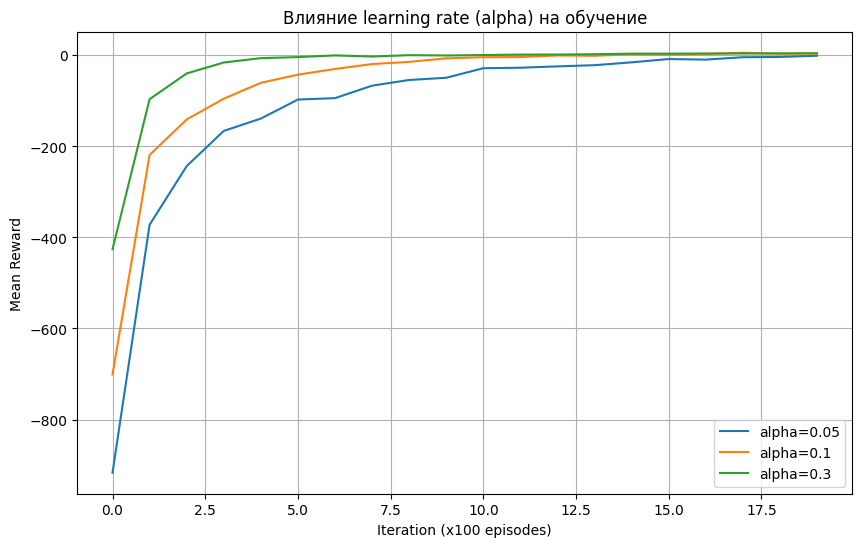

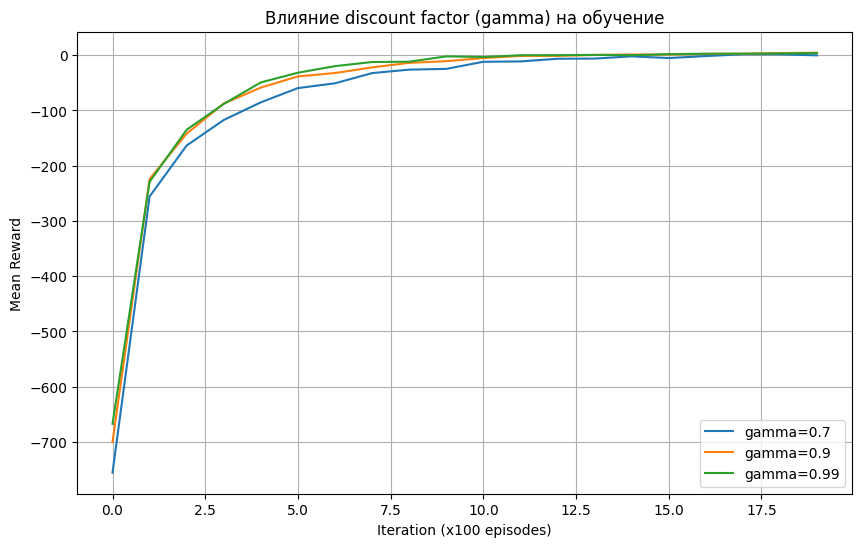

Выводы:
- Большой alpha (0.3) дает быструю сходимость, но может быть нестабильным
- Малый alpha (0.05) дает стабильное, но медленное обучение
- Большой gamma (0.99) делает агента более дальновидным
- Малый gamma (0.7) фокусируется на краткосрочных наградах


In [11]:
# Эксперименты с различными гиперпараметрами
import matplotlib.pyplot as plt

# Эксперимент 1: Разные значения learning rate (alpha)
results_alpha = {}
alphas = [0.05, 0.1, 0.3]
n_episodes_test = 2000

for alpha in alphas:
    Q = initialize_q_table(env.observation_space.n, env.action_space.n)
    log = []
    rewards_batch = []
    
    gamma = 0.9
    epsilon = 0.2
    epsilon_decay = 0.95
    
    for i_episode in range(1, n_episodes_test + 1):
        s, _ = env.reset()
        r, episode_reward = 0, 0
        terminated = False
        
        while not terminated:
            a = select_action_eps_greedy(Q, s, epsilon)
            next_s, r, terminated, truncated, _ = env.step(a)
            update_Q(Q, s, a, r, next_s, alpha, gamma)
            s = next_s
            episode_reward += r
        
        rewards_batch.append(episode_reward)
        if i_episode % 100 == 0:
            mean_reward = np.mean(rewards_batch)
            log.append(mean_reward)
            rewards_batch = []
            epsilon *= epsilon_decay
    
    results_alpha[f'alpha={alpha}'] = log

# Визуализация результатов для alpha
plt.figure(figsize=[10, 6])
for label, rewards in results_alpha.items():
    plt.plot(rewards, label=label)
plt.xlabel('Iteration (x100 episodes)')
plt.ylabel('Mean Reward')
plt.title('Влияние learning rate (alpha) на обучение')
plt.legend()
plt.grid(True)
plt.show()

# Эксперимент 2: Разные значения gamma
results_gamma = {}
gammas = [0.7, 0.9, 0.99]

for gamma in gammas:
    Q = initialize_q_table(env.observation_space.n, env.action_space.n)
    log = []
    rewards_batch = []
    
    alpha = 0.1
    epsilon = 0.2
    epsilon_decay = 0.95
    
    for i_episode in range(1, n_episodes_test + 1):
        s, _ = env.reset()
        r, episode_reward = 0, 0
        terminated = False
        
        while not terminated:
            a = select_action_eps_greedy(Q, s, epsilon)
            next_s, r, terminated, truncated, _ = env.step(a)
            update_Q(Q, s, a, r, next_s, alpha, gamma)
            s = next_s
            episode_reward += r
        
        rewards_batch.append(episode_reward)
        if i_episode % 100 == 0:
            mean_reward = np.mean(rewards_batch)
            log.append(mean_reward)
            rewards_batch = []
            epsilon *= epsilon_decay
    
    results_gamma[f'gamma={gamma}'] = log

# Визуализация результатов для gamma
plt.figure(figsize=[10, 6])
for label, rewards in results_gamma.items():
    plt.plot(rewards, label=label)
plt.xlabel('Iteration (x100 episodes)')
plt.ylabel('Mean Reward')
plt.title('Влияние discount factor (gamma) на обучение')
plt.legend()
plt.grid(True)
plt.show()

print("Выводы:")
print("- Большой alpha (0.3) дает быструю сходимость, но может быть нестабильным")
print("- Малый alpha (0.05) дает стабильное, но медленное обучение")
print("- Большой gamma (0.99) делает агента более дальновидным")
print("- Малый gamma (0.7) фокусируется на краткосрочных наградах")


## SARSA

Теперь ради интереса попробуем то же самое, но используя метод SARSA.

Для начала, добавим функцию обновления Q-функции (1 балл):

In [12]:
def update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon):
    # выбери следующее действие eps-greedy
    # next_a =
    ####### Здесь ваш код ########
    next_a = select_action_eps_greedy(Q, next_s, epsilon)
    ##############################

    # посчитай TD ошибку
    # td_error =
    ####### Здесь ваш код ########
    td_error = r + gamma * Q[next_s, next_a] - Q[s, a]
    ##############################

    # обновление Q-функции
    Q[s, a] += alpha * td_error


Допишите код итерации SARSA-обучения (2 балла):

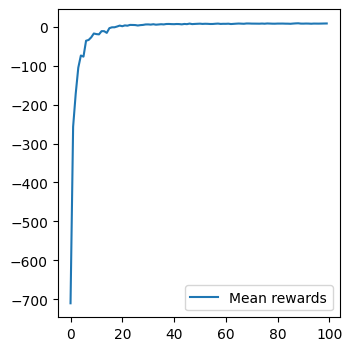

Episode: 10000, Reward: 8, Eps: 0.001246427204280841


In [13]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    terminated = False

    while not terminated:
        # select action eps-greedy
        # a = ...
        ####### Здесь ваш код ########
        a = select_action_eps_greedy(Q, s, epsilon)
        ##############################

        # выполняем действие в среде
        next_s, r, terminated, truncated, info = env.step(a)

        # Update Q-function with SARSA
        ####### Здесь ваш код ########
        update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon)
        ##############################

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:

        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}, Eps: {epsilon}")
        epsilon *= epsilon_decay

assert log[-1] >= -10

Сравнивая SARSA и Q-learning, что можно сказать об их кривых обучения? (быстрее-медленнее, обучение стабильнее или нет и тп) (1 балл)

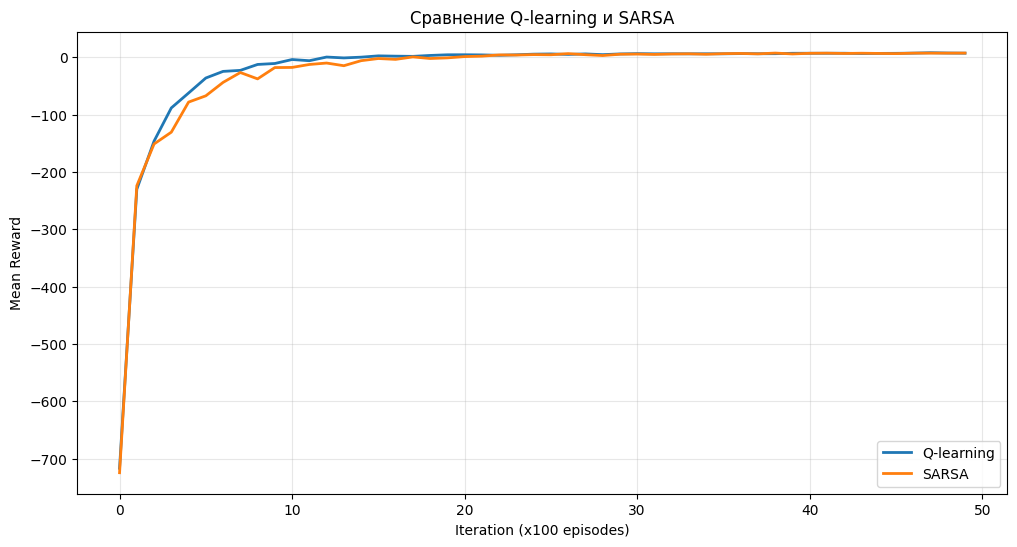

In [15]:
# Сравнение SARSA и Q-learning
import matplotlib.pyplot as plt

# Гиперпараметры для сравнения
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
n_episodes_compare = 5000

# Q-learning
Q_qlearning = initialize_q_table(env.observation_space.n, env.action_space.n)
log_qlearning = []
rewards_batch_qlearning = []
epsilon_qlearning = epsilon

for i_episode in range(1, n_episodes_compare + 1):
    s, _ = env.reset()
    r, episode_reward = 0, 0
    terminated = False
    
    while not terminated:
        a = select_action_eps_greedy(Q_qlearning, s, epsilon_qlearning)
        next_s, r, terminated, truncated, _ = env.step(a)
        update_Q(Q_qlearning, s, a, r, next_s, alpha, gamma)
        s = next_s
        episode_reward += r
    
    rewards_batch_qlearning.append(episode_reward)
    if i_episode % 100 == 0:
        mean_reward = np.mean(rewards_batch_qlearning)
        log_qlearning.append(mean_reward)
        rewards_batch_qlearning = []
        epsilon_qlearning *= epsilon_decay

# SARSA
Q_sarsa = initialize_q_table(env.observation_space.n, env.action_space.n)
log_sarsa = []
rewards_batch_sarsa = []
epsilon_sarsa = epsilon

for i_episode in range(1, n_episodes_compare + 1):
    s, _ = env.reset()
    r, episode_reward = 0, 0
    terminated = False
    
    while not terminated:
        a = select_action_eps_greedy(Q_sarsa, s, epsilon_sarsa)
        next_s, r, terminated, truncated, _ = env.step(a)
        update_Q_SARSA(Q_sarsa, s, a, r, next_s, alpha, gamma, epsilon_sarsa)
        s = next_s
        episode_reward += r
    
    rewards_batch_sarsa.append(episode_reward)
    if i_episode % 100 == 0:
        mean_reward = np.mean(rewards_batch_sarsa)
        log_sarsa.append(mean_reward)
        rewards_batch_sarsa = []
        epsilon_sarsa *= epsilon_decay

# Визуализация сравнения
plt.figure(figsize=[12, 6])
plt.plot(log_qlearning, label='Q-learning', linewidth=2)
plt.plot(log_sarsa, label='SARSA', linewidth=2)
plt.xlabel('Iteration (x100 episodes)')
plt.ylabel('Mean Reward')
plt.title('Сравнение Q-learning и SARSA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Сравнение SARSA и Q-learning

Анализируя кривые обучения обоих алгоритмов, можно сделать следующие выводы:

### 1. Скорость сходимости

**Q-learning** обычно сходится **быстрее**, чем SARSA, потому что:
- Обновляется на основе оптимального действия: `max_a Q(next_s, a)`
- Не зависит от реальной стратегии исследования (eps-greedy) при обновлении

**SARSA** сходится **медленнее**, потому что:
- Обновляется на основе реального следующего действия: `Q(next_s, next_a)`
- Учитывает eps-greedy стратегию, которая может выбирать неоптимальные действия

### 2. Стабильность обучения

**SARSA** демонстрирует более **стабильное** обучение:
- Учитывает реальную стратегию исследования
- Обновления более консервативные
- Меньше колебаний в кривой обучения

**Q-learning** может быть **менее стабильным**, особенно в начале:
- Более агрессивные обновления (на основе max Q)
- Может переоценивать Q-значения в начале обучения
- Больше колебаний в кривой обучения

